In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp
from numba import jit

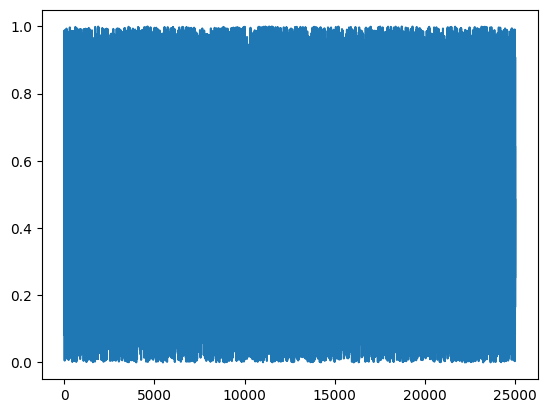

In [33]:
n = 50
p = 500
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
#  we let r=25
r = 30
y = np.zeros(n) #initialising y array
sigmay = 1
for i in range(n):
    yTemp = X[i][0:r].sum() + np.random.normal(0, sigmay) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [23]:
def splitGibbs(sigma1, sigma2, sigmay, X, y, niter=1000):
    gamma = 0.1
    rho = 1
    p = len(X[1])
    n = len(X)
    b = p + n
    theta = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
    # for i in range(r): theta[i] = 1                                
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])             #initialising numpy array to store A^t * z and z
    samples = []
    for i in range(b):                                                  #generating A and A^t * A and storing them into numpy array
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            if i == 0:
                Alist = A
                AtA = np.array([np.matmul(A.T, A)])
            else:
                Alist = np.vstack((Alist, A))
                AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

    for t in range(niter):                                              #Beginning of Split Gibbs Sampling
        for i in range(b):
            if i <= p-1:
                sigsig = sigma2 / sigma1
                Aitheta = np.matmul(Alist[i], theta)
                sigmaz = 1 - sigsig**2
                w2 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(sigmaz) * (np.linalg.norm(Aitheta))**2/2)))
                w1 = 1 - w2
                U = np.random.uniform(0,1)
                if U > w2:
                    mu = (sigmaz) * Aitheta
                    z = np.append(z, np.random.normal(mu, sigmaz))
                else:
                    z = np.append(z, 0)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
            else:
                z = np.append(z, y[i-p] / sigmay)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))

        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
        samples.append(theta.T[0])

    # print("Number of samples is" % str(len(samples)))
    return np.asarray(samples)


# trace = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 100000)

In [24]:
@jit
def compNormal_include(theta_i, gamma, sigma1, sigma2):
    return (gamma * sigma2 * np.exp(-((theta_i**2)/(2*(sigma1**2)))))

@jit
def compNormal_exclude(theta_i, gamma, sigma1, sigma2):
    return ((sigma1-(gamma*sigma1)) * np.exp(-((theta_i**2)/(2*(sigma2**2)))))

@jit
def compNormal_data(theta, y, X, sigmay):
    ssum = 0
    for j in range(len(X)):
        ssum += ((y[j] - np.matmul(X[j], theta))**2)/(2*(sigmay**2))
    return ssum

@jit
def ssp(theta, gamma, X, sigma1, sigma2):
    ssum = 0
    for i in range(len(X[1])):
        ssum += np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2))
        # print(np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2)))
    return ssum

In [25]:
def metroHastings(sigma1, sigma2, sigmay, sigma_theta, X, y, niter = 1000):
    p = len(X[1])
    n = len(X)
    b = p + n
    t = 1
    gamma = 0.1
    no_accept = 0
    theta_0 = np.array([np.zeros(p)]).T                                     #--- initialising theta as zero vectors
    # theta_0 = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1))
    # for i in range(r): theta_0[i] = 1
    thetas = theta_0.T[0]

    while t < niter:
        t += 1
        #symmetric random walk
        theta_c = np.reshape(np.random.multivariate_normal(theta_0.T[0], np.identity(p)*sigma_theta), (-1, 1))
        log_joint_candidate = ssp(theta_c, gamma, X, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
        log_joint_old = ssp(theta_0, gamma, X, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
        mhr = np.exp(log_joint_candidate - log_joint_old)                   #--- To lessen change of underflows/overflows with MHR
        # print(mhr)
        U = np.random.uniform(0,1)
        if U <= np.minimum(mhr, 1):
            theta_0 = theta_c
            thetas = np.vstack((thetas, theta_c.T[0]))
            no_accept += 1
        else:
            thetas = np.vstack((thetas, theta_0.T[0]))
            # print(thetas)
    
    print("Acceptance Rate is %s, with total number of acceptance of %s" % (str(no_accept/niter), str(no_accept)))
    return thetas


# samples = metroHastings(sigma1 = 1, sigma2 = 0.01, sigmay = 0.01, sigma_theta = 1, X = X, y = y, niter = 50000)
# samples = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, sigma_theta = 1, X = X, y = y, niter = 100000)

tf.Tensor(
[ 1.62280157e-01  6.62386939e-02  1.52666762e-01  1.41597301e-01
  2.77685642e-01  7.48297805e-03  2.43842989e-01  2.07264647e-01
  1.76285729e-01  2.45547220e-01  1.48512661e-01  2.04852402e-01
  1.99843794e-01  2.04145610e-01  1.92813247e-01  2.17835963e-01
  2.16481596e-01  1.93502069e-01  1.67020708e-01  1.00629091e-01
  4.75175194e-02  3.71573605e-02  1.61701664e-01  2.05962583e-01
  1.30063042e-01  2.49545962e-01  1.92305818e-01  2.16573521e-01
  1.30981117e-01  3.53989713e-02  9.40988958e-02 -5.03742136e-03
  1.05493084e-01  2.46432219e-02  1.16751619e-01  8.97587314e-02
  4.64671664e-02 -2.97617577e-02  7.31801242e-02  8.27070102e-02
 -1.45711529e-03 -8.44441541e-03 -1.73180345e-02  1.73919261e-01
  1.36981666e-01 -1.51370689e-01  1.55510515e-01 -2.18663495e-02
  8.57183710e-02  6.85453340e-02  1.52974829e-01 -1.40871871e-02
  8.34277049e-02  5.51303029e-02  8.85569304e-03  3.40296812e-02
 -9.03395712e-02  5.89860417e-02  1.02982439e-01  9.87016484e-02
 -1.45925656e-

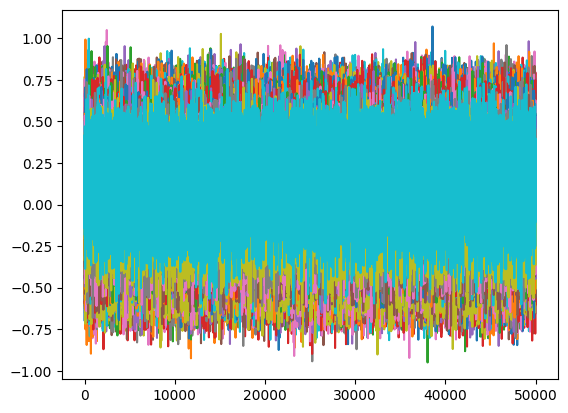

In [26]:
traceSGS = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, X = X, y = y, niter = 50000)

sampleSGS = tf.convert_to_tensor(traceSGS, dtype=tf.float32)
plt.plot(sampleSGS)
meanSGS, varianceSgs = tf.nn.moments(sampleSGS, axes=0)
print(meanSGS)

Acceptance Rate is 0.27532, with total number of acceptance of 6883
tf.Tensor(
[ 4.01479825e-02  1.25832530e-02  1.91790350e-02  2.51055732e-02
 -5.44549339e-03  1.07478976e-01  7.42693394e-02  1.14366459e-02
  1.15156788e-02  9.79663581e-02  1.01418458e-01  1.00093687e+00
  1.40153402e-02  4.17896472e-02  3.48898992e-02  2.34440863e-01
  8.56423914e-01  5.46491100e-03  8.06889236e-02  1.47608787e-01
  3.70327145e-01  3.09249070e-02  6.66186288e-02 -1.99414368e-04
  1.93617389e-01  5.78198917e-02 -6.83654845e-03  3.96694057e-02
  6.01401255e-02  6.20402060e-02  9.99616683e-02 -5.39075304e-03
  1.53102065e-02  5.31835621e-03  4.35398109e-02  6.25035074e-03
  1.54753849e-02  2.64660604e-02 -3.86971682e-02 -1.65565889e-02
  4.77074608e-02  5.80885541e-03  4.22389470e-02 -2.39738077e-02
  4.47618812e-02  9.72933397e-02 -1.26930606e-02  6.07479410e-03
  5.17474487e-03  5.70024513e-02 -2.76927068e-03  2.20510690e-03
 -2.61888094e-02 -4.06865887e-02  3.49287689e-02  1.63156903e+00
  5.8688037

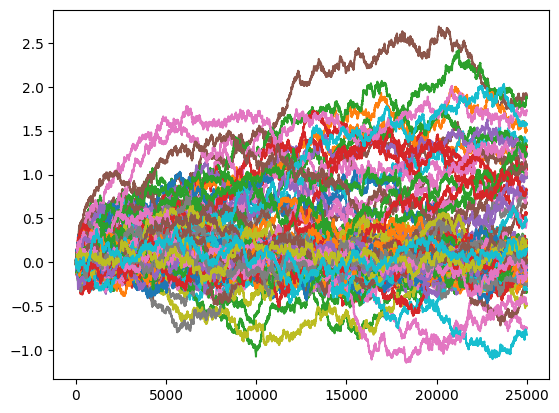

In [35]:
traceMh = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, sigma_theta = 0.0001, X = X, y = y, niter = 25000)
sampleMh = tf.convert_to_tensor(traceMh, dtype = tf.float32)
plt.plot(sampleMh)
# mean-mh, variance = tf.nn.moments(trace, axes=0)
meanMh = tf.math.reduce_mean(sampleMh, axis=0)
print(meanMh)